In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# Wrangle

In [2]:
df = pd.read_csv('store_item_demand.csv')

In [3]:
df.head()

,sale_id,sale_date,store_id,item_id,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state
0,1,2013-01-01,1,1,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,2,2013-01-02,1,1,11,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2,3,2013-01-03,1,1,14,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
3,4,2013-01-04,1,1,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
4,5,2013-01-05,1,1,10,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


In [4]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

df = df[df.index != '2016-02-29']

In [5]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-01 to 2017-12-31
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dollars_sold  1825 non-null   float64
 1   items_sold    1825 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 42.8 KB


In [7]:
df.shape

(1825, 2)

# Split

In [8]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

## Verify Splits

In [9]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [10]:
print(df.head(1) == train.head(1))

            dollars_sold  items_sold
ds                                  
2013-01-01          True        True


In [11]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30,120033.64,22296
2016-12-31,128009.31,23792


In [12]:
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31,140905.74,26420
2017-12-31,140905.74,26420


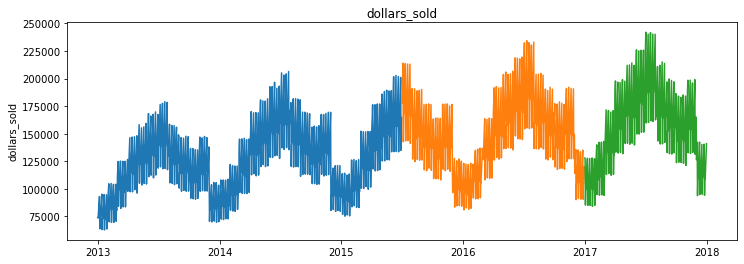

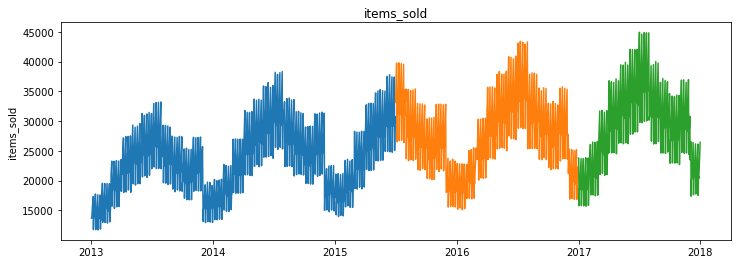

In [13]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Helper Functions

In [14]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [15]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [16]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [17]:
eval_df

,model_type,target_var,rmse


# Forecast

## Last observed value

- making predictions based off of the most recent occurance 

### Make Predictions

In [18]:
items = train['items_sold'][-1:][0]
dollars = round(train['dollars_sold'][-1:][0],2)

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, 
                       index = validate.index)

yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02,30703,164573.2
2015-07-03,30703,164573.2


### Plot Actual vs. Predicted Values

dollars_sold -- RMSE: 35402


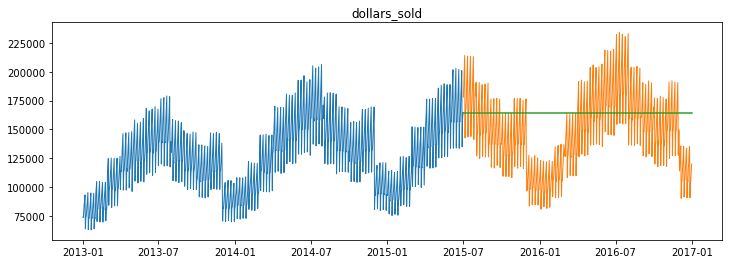

items_sold -- RMSE: 6621


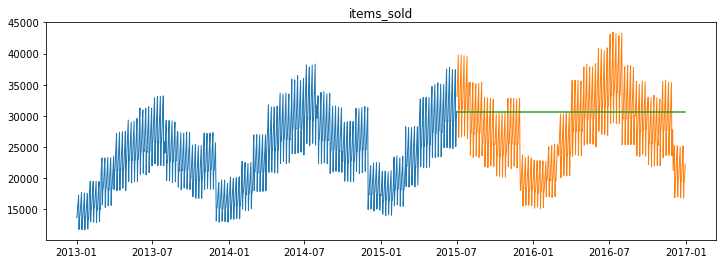

In [19]:
for col in train.columns:
    plot_and_eval(col)
    
## the green bar represents predictions

## this model assumes all forecasted predictions will be equal to the last observation chronologically

### Evaluate

In [20]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

## Simple Average

- predictions will be based off of all time historical average 

### Make Predictions

In [21]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [22]:
yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02,23717.94,127517.85
2015-07-03,23717.94,127517.85


### Plot Actual vs. Predicted Values

dollars_sold -- RMSE: 39664


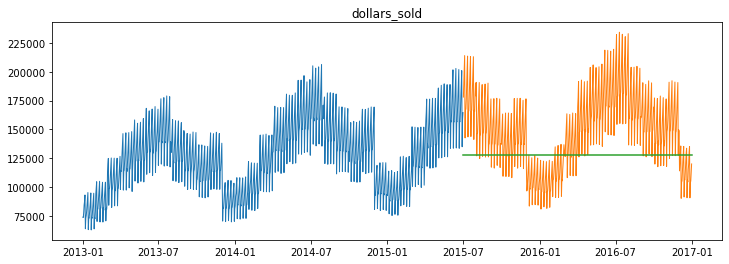

items_sold -- RMSE: 7378


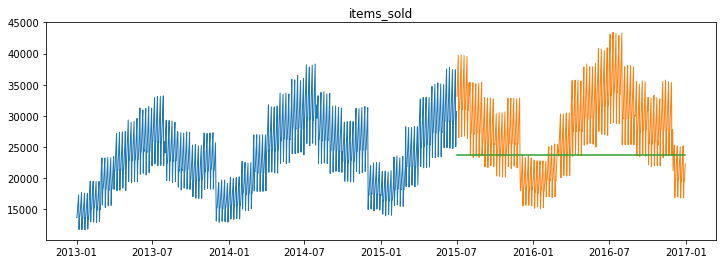

In [23]:
for col in train.columns:
    plot_and_eval(col)
    
## here our model predicted that the value would be indentical to the historical average

## this model performed worse than Last Observed Value with a higher RMSE

### Evaluate

In [24]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

## Moving Average

- predictions will be based off the average of a specified recent timeframe

### Make Predictions

In [25]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-02,31432.77,168957.91
2015-07-03,31432.77,168957.91
2015-07-04,31432.77,168957.91


### Plot Actual vs. Predicted Values

dollars_sold -- RMSE: 37378


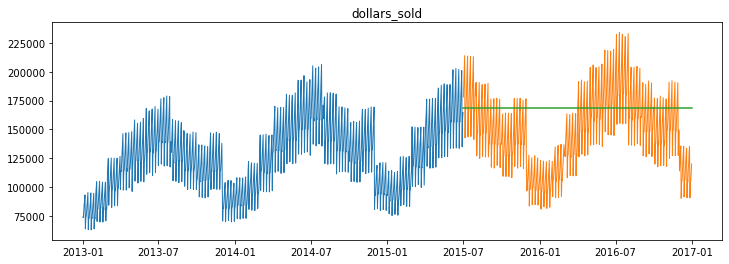

items_sold -- RMSE: 6954


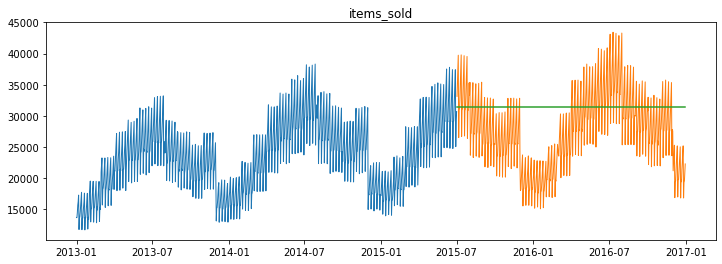

In [26]:
for col in train.columns:
    plot_and_eval(col)
    
## This model predicts the value will be equal to the historic average of only the most recent 30 days

## This model still underperforms compared to the Last Observed Value model

### Evaluate

In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

#### Try out other timeframes 

In [28]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [29]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0
6,1d moving average,items_sold,6621.0
7,1d moving average,dollars_sold,35402.0
8,4d moving average,items_sold,6592.0
9,4d moving average,dollars_sold,35515.0


In [30]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

## the Rolling Average model with a time period of 104 days does the best overall at predicting correctly 

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
17,104d moving average,dollars_sold,32803.0


## Holt's Linear Trend

- precidtions will be based off of a linear trend obsverved in the training data

### Seasonal Decomposition

dollars_sold 



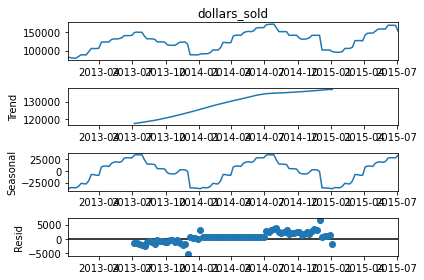

items_sold 



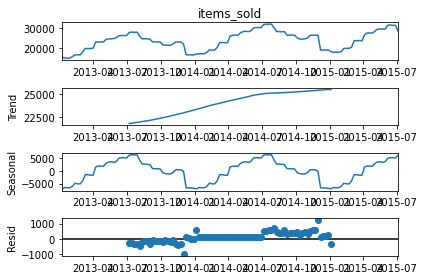

In [31]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()
    

### Basic Holt's Linear Trend

#### Make Predictions

In [32]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

#### Plot Actual vs. Predicted Values

dollars_sold -- RMSE: 34700


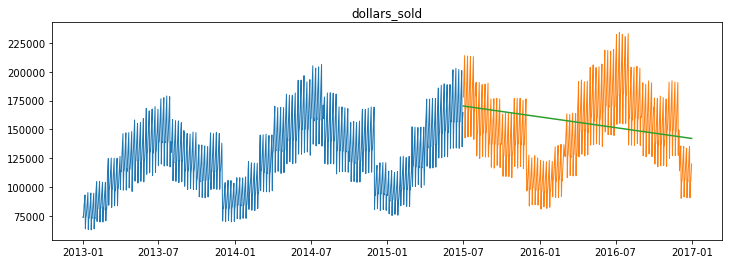

items_sold -- RMSE: 6464


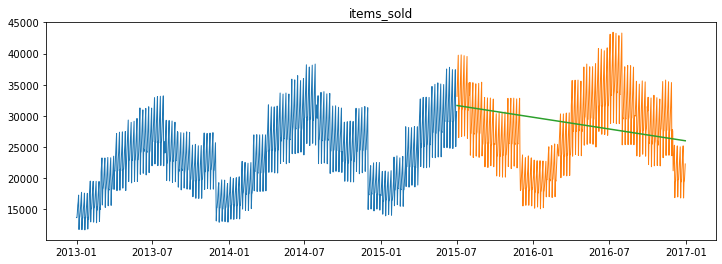

In [33]:
for col in train.columns:
    plot_and_eval(target_var = col)
    
## this model found the linear trend and made predictions based off of it

## this model outperforms the Last Observed Value, but does not outperform the 104d Rolling Average

#### Evaluate

In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

## Predict Based on Previous Cycle

- predictions will be based off of the most recent cycle

### Re-split data

In [35]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

## resplit data so each df is it's own cycle

### Make Predictions

In [36]:
yhat_df = train['2015'] + train.diff(365).mean()

In [37]:
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-01-01,104337.620493,19411.813699
2016-01-01,107875.260000,20158.000000


In [38]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

### Plot and Evaluate

dollars_sold -- RMSE: 28087


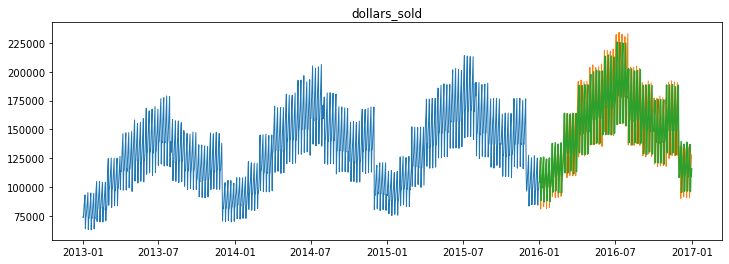

items_sold -- RMSE: 5223


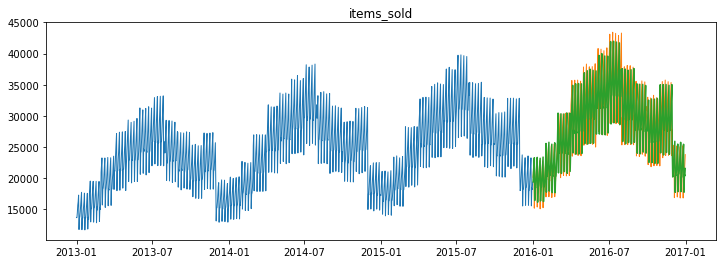

In [39]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)
    
## this model recognized the pattern in cycles and made its predictions based off of previous cycles

## This model has outperformed all other models at making the most accurate predictions 

# Conclusion

In [40]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

## The model making predictions based off of the previous year did the best overall 

,model_type,target_var,rmse
20,previous year,dollars_sold,28087.0
21,previous year,items_sold,5223.0


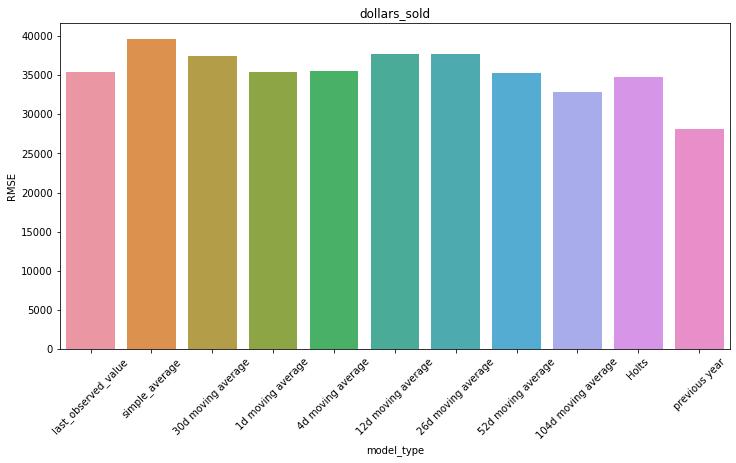

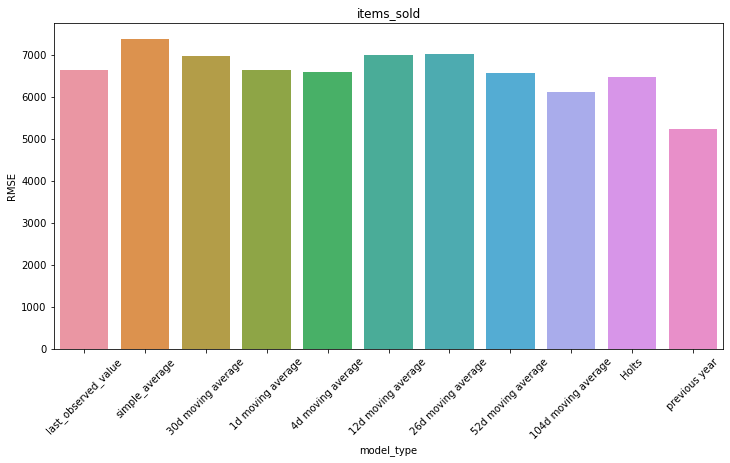

In [41]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()
    
## previous year model has the lowest RMSE 

In [42]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

## since previous year has the best performance we will test it on the test df

In [43]:
rmse_dollars = round(sqrt(mean_squared_error(test['dollars_sold'], yhat_df['dollars_sold'])), 0)
rmse_items = round(sqrt(mean_squared_error(test['items_sold'], yhat_df['items_sold'])), 0)

In [44]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

rmse - dollars_sold:  27115.0
rmse - items_sold:  5041.0


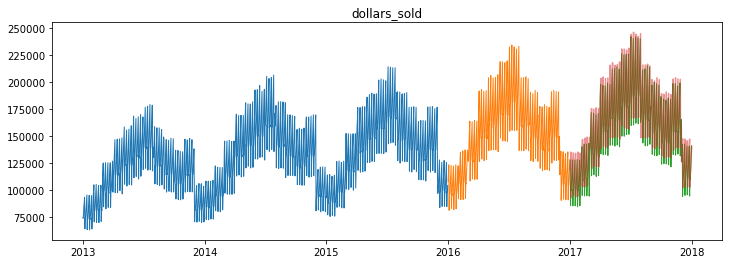

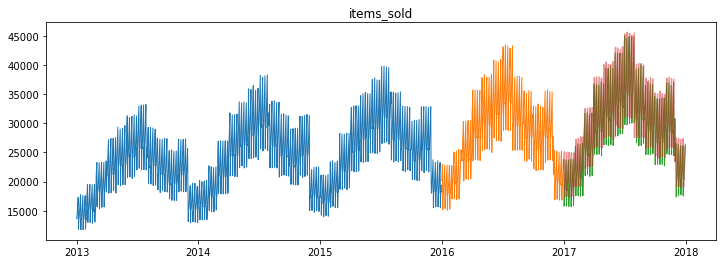

In [45]:
print("rmse - dollars_sold: ", rmse_dollars)
print("rmse - items_sold: ", rmse_items)

for col in train.columns:
    plot_and_eval(col)

In [46]:
## our final model still outperforms the other models on unseen test data